In [1]:
import pandas as pd # Clean up.
import numpy as np
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from google.colab import files
from google.colab import drive
import glob
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import os
from keras.models import load_model   
from keras.utils import np_utils
from keras import applications
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint

In [2]:
drive.mount('/content/drive')
uploaded = files.upload()
dataframe = pd.read_csv('benign-and-malignant-images-labels-final.csv')
directory = '/content/drive/MyDrive/ML Project/Retinoblastoma-Project (current)/Data (current)/Benign-and-Malignant-Images'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving benign-and-malignant-images-labels-final.csv to benign-and-malignant-images-labels-final (1).csv


In [3]:
image_list = []
for i in range(1, 282):
  filename = directory + "/" + str(i) + ".jpg"
  image = load_img(filename, target_size = (224, 224))
  image_list.append(np.array(image))

In [4]:
for i in range(281): 
    if dataframe['benign_malignant'][i] == "malignant":
        dataframe['benign_malignant'][i] = 1
    elif dataframe['benign_malignant'][i] == "benign":
        dataframe['benign_malignant'][i] = 0
    else:
        dataframe['benign_malignant'][i] = -1

<ipython-input-4-1b4dba39b1f7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['benign_malignant'][i] = 1
<ipython-input-4-1b4dba39b1f7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['benign_malignant'][i] = 0


In [5]:
dataframe['images'] = image_list

In [6]:
dataframeShuffled = shuffle(dataframe)

In [7]:
train_ds, test_ds, train_labels, test_labels = train_test_split(dataframeShuffled['images'].tolist(), dataframeShuffled['benign_malignant'], test_size =  0.33, random_state = 1) 
train_labels_processed = to_categorical(train_labels, num_classes=5)
test_labels_processed = to_categorical(test_labels, num_classes=5)

In [8]:
train_ds = tf.image.resize(train_ds, (224, 224))
test_ds = tf.image.resize(test_ds, (224, 224))

In [9]:
img_height,img_width = 224, 224 
num_classes = 5 # ? ? ?
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
base_model = ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

In [10]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

In [11]:
from keras.optimizers import SGD, Adam
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

results = model.fit(train_ds, train_labels_processed, epochs = 4, validation_split = 0.4, batch_size = 16, callbacks = [es]) # Hyperparameters, check these for all models, also do new metrics and confusion matrix and graphs for new metrics.

Epoch 1/4
7/7 [==============================] - 123s 17s/step - loss: 2.0365 - accuracy: 0.5268 - val_loss: 6.6451 - val_accuracy: 0.5132
Epoch 2/4
7/7 [==============================] - 107s 16s/step - loss: 0.9446 - accuracy: 0.8393 - val_loss: 2.7231 - val_accuracy: 0.5132
Epoch 3/4
7/7 [==============================] - 103s 15s/step - loss: 0.5007 - accuracy: 0.8750 - val_loss: 1.1275 - val_accuracy: 0.6316
Epoch 4/4
7/7 [==============================] - 103s 15s/step - loss: 0.3221 - accuracy: 0.8839 - val_loss: 0.7862 - val_accuracy: 0.8553


Text(0.5, 1.0, 'Loss')

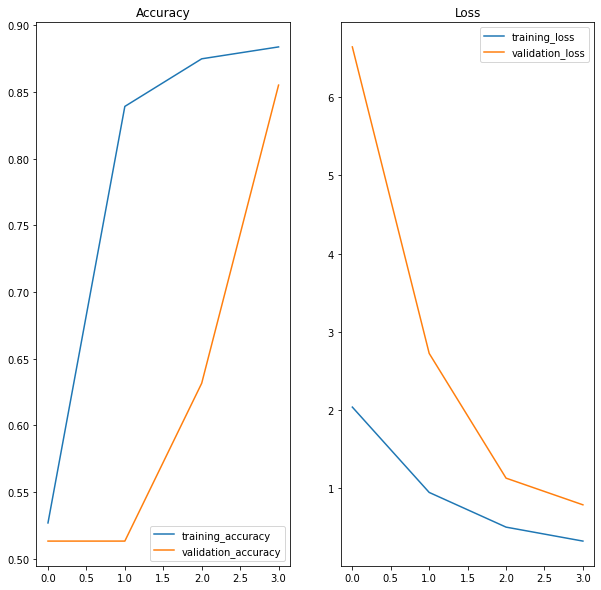

In [13]:
accuracy = results.history['accuracy']
validation_accuracy = results.history['val_accuracy']
loss = results.history['loss']
validation_loss = results.history['val_loss']
epoch_number = range(4) # Changes depending on how many epochs were run before the early stop.

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epoch_number, accuracy, label = 'training_accuracy')
plt.plot(epoch_number, validation_accuracy, label = 'validation_accuracy')
plt.legend(loc = 'lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epoch_number, loss, label = 'training_loss')
plt.plot(epoch_number, validation_loss, label = 'validation_loss')
plt.legend(loc = 'upper right')
plt.title('Loss')

In [14]:
preds = model.evaluate(test_ds, test_labels_processed)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

3/3 [==============================] - 19s 5s/step - loss: 0.7493 - accuracy: 0.8280
Loss = 0.7492754459381104
Test Accuracy = 0.8279569745063782


In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [16]:
preds = model.predict(test_ds)
predictions = []
for i in range(0, 93):
  predictions.append(np.argmax(tf.nn.softmax(preds[i])))

3/3 [==============================] - 20s 6s/step


In [17]:
len(predictions)

93

In [18]:
!pip install torchmetrics
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.6/518.6 KB 24.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
from torchmetrics import JaccardIndex
from torchmetrics.functional import dice
import torch

In [20]:
jaccard = JaccardIndex(task="multiclass", num_classes=2)

In [21]:
print("This is the Jaccard index: " + str(jaccard(torch.from_numpy(np.array(predictions)), torch.from_numpy(np.array(test_labels).astype('float32')))))
print("This is the Dice Similarity Coefficient: " + str(dice(torch.from_numpy(np.array(test_labels).astype('float32')), torch.from_numpy(np.array(predictions)), average = 'micro')))

This is the Jaccard index: tensor(0.7052)
This is the Dice Similarity Coefficient: tensor(0.8400)


In [22]:
from sklearn.metrics import confusion_matrix
x = confusion_matrix(torch.from_numpy(np.array(test_labels).astype('float32')), np.array(predictions))
x

array([[35, 11],
       [ 5, 42]])

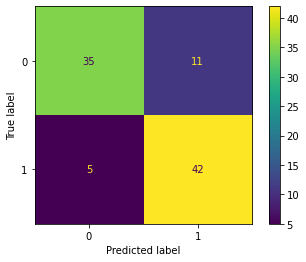

In [23]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# X, y = make_classification(random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                    random_state=0)
# clf = SVC(random_state=0)
# clf.fit(X_train, y_train)

# predictions = clf.predict(X_test)
# cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=x,
                              display_labels={0, 1})
disp.plot()

plt.show()